# Codegen Tutorial

One of the most important features of symforce is the ability to generate computationally efficient code from symbolic expressions. Before progressing, first make sure you are familiar with the other symforce tutorials, especially the [Values tutorial](../tutorials/values_tutorial.html).

The typical workflow for generating a function is to define a Python function that operates on symbolic inputs to return the symbolic result.  Typically this will look like:

1. Define a Python function that operates on symbolic inputs
2. Create a Codegen object using `Codegen.function`.  Various properties of the function will be deduced automatically; for instance, the name of the generated function is generated from the name of the Python function, and the argument names and types are deduced from the Python function argument names and type annotations.
3. Generate the code in your desired language

Alternately, you may want to define the input and output symbolic `Values` explicitly, with the following steps:

1. Build an input Values object that defines a symbolic representation of each input to the function. Note that inputs and outputs can be Values objects themselves, which symforce will automatically generate into custom types.
2. Build an output Values object that defines the outputs of the function in terms of the objects in the input Values.
3. Generate the code in your desired language

In [1]:
# Setup
import numpy as np

import symforce

symforce.set_symbolic_api("symengine")
symforce.set_log_level("warning")

# Set epsilon to a symbol for safe code generation.  For more information, see the Epsilon tutorial:
# https://symforce.org/tutorials/epsilon_tutorial.html
symforce.set_epsilon_to_symbol()

import symforce.symbolic as sf
from symforce import codegen
from symforce.codegen import codegen_util
from symforce.notebook_util import display
from symforce.notebook_util import display_code_file
from symforce.notebook_util import set_notebook_defaults
from symforce.values import Values

set_notebook_defaults()

/opt/hostedtoolcache/Python/3.8.18/x64/lib/python3.8/site-packages/setuptools_scm/git.py:167: UserWarning: "/home/runner/work/symforce/symforce" is shallow and may cause errors
  warnings.warn(f'"{wd.path}" is shallow and may cause errors')


## Generating from a Python function

First, we look at using existing python functions to generate an equivalent function using the codegen package. The inputs to the function are automatically deduced from the signature and type annotations.  Additionally, we can change how the generated function is declared (e.g. whether to return an object using a return statement or a pointer passed as an argument to the function).

In [2]:
def az_el_from_point(
    nav_T_cam: sf.Pose3, nav_t_point: sf.Vector3, epsilon: sf.Scalar = 0
) -> sf.Vector2:
    """
    Transform a nav point into azimuth / elevation angles in the
    camera frame.

    Args:
        nav_T_cam (sf.Pose3): camera pose in the world
        nav_t_point (sf.Matrix): nav point
        epsilon (Scalar): small number to avoid singularities

    Returns:
        sf.Matrix: (azimuth, elevation)
    """
    cam_t_point = nav_T_cam.inverse() * nav_t_point
    x, y, z = cam_t_point
    theta = sf.atan2(y, x + epsilon)
    phi = sf.pi / 2 - sf.acos(z / (cam_t_point.norm() + epsilon))
    return sf.V2(theta, phi)

In [3]:
az_el_codegen = codegen.Codegen.function(
    func=az_el_from_point,
    config=codegen.CppConfig(),
)
az_el_codegen_data = az_el_codegen.generate_function()

print("Files generated in {}:\n".format(az_el_codegen_data.output_dir))
for f in az_el_codegen_data.generated_files:
    print("  |- {}".format(f.relative_to(az_el_codegen_data.output_dir)))

display_code_file(az_el_codegen_data.generated_files[0], "C++")

Files generated in /tmp/sf_codegen_az_el_from_point_jquts88p:

  |- cpp/symforce/sym/az_el_from_point.h


// -----------------------------------------------------------------------------
// This file was autogenerated by symforce from template:
//     function/FUNCTION.h.jinja
// Do NOT modify by hand.
// -----------------------------------------------------------------------------

#pragma once

#include <Eigen/Core>

#include <sym/pose3.h>

namespace sym {

/**
 * Transform a nav point into azimuth / elevation angles in the
 * camera frame.
 *
 * Args:
 *     nav_T_cam (sf.Pose3): camera pose in the world
 *     nav_t_point (sf.Matrix): nav point
 *     epsilon (Scalar): small number to avoid singularities
 *
 * Returns:
 *     sf.Matrix: (azimuth, elevation)
 */
template <typename Scalar>
Eigen::Matrix<Scalar, 2, 1> AzElFromPoint(const sym::Pose3<Scalar>& nav_T_cam,
                                          const Eigen::Matrix<Scalar, 3, 1>& nav_t_point,
                                          const Scalar epsilon) {
  // Total ops: 79

  // Input arrays
  const Eigen::Matrix<Scalar, 7, 1>& _nav_T_cam = nav_T_cam.Data();

  // Intermediate terms (24)
  const Scalar _tmp0 = 2 * _nav_T_cam[0];
  const Scalar _tmp1 = _nav_T_cam[3] * _tmp0;
  const Scalar _tmp2 = 2 * _nav_T_cam[1];
  const Scalar _tmp3 = _nav_T_cam[2] * _tmp2;
  const Scalar _tmp4 = _tmp1 + _tmp3;
  const Scalar _tmp5 = _nav_T_cam[1] * _tmp0;
  const Scalar _tmp6 = 2 * _nav_T_cam[2] * _nav_T_cam[3];
  const Scalar _tmp7 = _tmp5 - _tmp6;
  const Scalar _tmp8 = -2 * std::pow(_nav_T_cam[0], Scalar(2));
  const Scalar _tmp9 = 1 - 2 * std::pow(_nav_T_cam[2], Scalar(2));
  const Scalar _tmp10 = _tmp8 + _tmp9;
  const Scalar _tmp11 = -_nav_T_cam[4] * _tmp7 - _nav_T_cam[5] * _tmp10 - _nav_T_cam[6] * _tmp4 +
                        _tmp10 * nav_t_point(1, 0) + _tmp4 * nav_t_point(2, 0) +
                        _tmp7 * nav_t_point(0, 0);
  const Scalar _tmp12 = _nav_T_cam[3] * _tmp2;
  const Scalar _tmp13 = _nav_T_cam[2] * _tmp0;
  const Scalar _tmp14 = -_tmp12 + _tmp13;
  const Scalar _tmp15 = _tmp5 + _tmp6;
  const Scalar _tmp16 = -2 * std::pow(_nav_T_cam[1], Scalar(2));
  const Scalar _tmp17 = _tmp16 + _tmp9;
  const Scalar _tmp18 = -_nav_T_cam[4] * _tmp17 - _nav_T_cam[5] * _tmp15 - _nav_T_cam[6] * _tmp14 +
                        _tmp14 * nav_t_point(2, 0) + _tmp15 * nav_t_point(1, 0) +
                        _tmp17 * nav_t_point(0, 0);
  const Scalar _tmp19 = _tmp18 + epsilon;
  const Scalar _tmp20 = -_tmp1 + _tmp3;
  const Scalar _tmp21 = _tmp12 + _tmp13;
  const Scalar _tmp22 = _tmp16 + _tmp8 + 1;
  const Scalar _tmp23 = -_nav_T_cam[4] * _tmp21 - _nav_T_cam[5] * _tmp20 - _nav_T_cam[6] * _tmp22 +
                        _tmp20 * nav_t_point(1, 0) + _tmp21 * nav_t_point(0, 0) +
                        _tmp22 * nav_t_point(2, 0);

  // Output terms (1)
  Eigen::Matrix<Scalar, 2, 1> _res;

  _res(0, 0) =
      std::atan2(_tmp11, _tmp19 + epsilon * ((((_tmp19) > 0) - ((_tmp19) < 0)) + Scalar(0.5)));
  _res(1, 0) =
      -std::acos(_tmp23 / (epsilon + std::sqrt(Scalar(std::pow(_tmp11, Scalar(2)) +
                                                      std::pow(_tmp18, Scalar(2)) +
                                                      std::pow(_tmp23, Scalar(2)) + epsilon)))) +
      Scalar(M_PI_2);

  return _res;
}  // NOLINT(readability/fn_size)

// NOLINTNEXTLINE(readability/fn_size)
}  // namespace sym

## Generating function jacobians

In [4]:
codegen_with_jacobians = az_el_codegen.with_jacobians(
    # Just compute wrt the pose and point, not epsilon
    which_args=["nav_T_cam", "nav_t_point"],
    # Include value, not just jacobians
    include_results=True,
)

data = codegen_with_jacobians.generate_function()

display_code_file(data.generated_files[0], "C++")

// -----------------------------------------------------------------------------
// This file was autogenerated by symforce from template:
//     function/FUNCTION.h.jinja
// Do NOT modify by hand.
// -----------------------------------------------------------------------------

#pragma once

#include <Eigen/Core>

#include <sym/pose3.h>

namespace sym {

/**
 * Transform a nav point into azimuth / elevation angles in the
 * camera frame.
 *
 * Args:
 *     nav_T_cam (sf.Pose3): camera pose in the world
 *     nav_t_point (sf.Matrix): nav point
 *     epsilon (Scalar): small number to avoid singularities
 *
 * Returns:
 *     sf.Matrix: (azimuth, elevation)
 *     res_D_nav_T_cam: (2x6) jacobian of res (2) wrt arg nav_T_cam (6)
 *     res_D_nav_t_point: (2x3) jacobian of res (2) wrt arg nav_t_point (3)
 */
template <typename Scalar>
Eigen::Matrix<Scalar, 2, 1> AzElFromPointWithJacobians01(
    const sym::Pose3<Scalar>& nav_T_cam, const Eigen::Matrix<Scalar, 3, 1>& nav_t_point,
    const Scalar epsilon, Eigen::Matrix<Scalar, 2, 6>* const res_D_nav_T_cam = nullptr,
    Eigen::Matrix<Scalar, 2, 3>* const res_D_nav_t_point = nullptr) {
  // Total ops: 290

  // Input arrays
  const Eigen::Matrix<Scalar, 7, 1>& _nav_T_cam = nav_T_cam.Data();

  // Intermediate terms (93)
  const Scalar _tmp0 = 2 * _nav_T_cam[0];
  const Scalar _tmp1 = _nav_T_cam[3] * _tmp0;
  const Scalar _tmp2 = 2 * _nav_T_cam[1];
  const Scalar _tmp3 = _nav_T_cam[2] * _tmp2;
  const Scalar _tmp4 = _tmp1 + _tmp3;
  const Scalar _tmp5 = _nav_T_cam[6] * _tmp4;
  const Scalar _tmp6 = _nav_T_cam[1] * _tmp0;
  const Scalar _tmp7 = 2 * _nav_T_cam[2] * _nav_T_cam[3];
  const Scalar _tmp8 = -_tmp7;
  const Scalar _tmp9 = _tmp6 + _tmp8;
  const Scalar _tmp10 = _nav_T_cam[4] * _tmp9;
  const Scalar _tmp11 = std::pow(_nav_T_cam[0], Scalar(2));
  const Scalar _tmp12 = 2 * _tmp11;
  const Scalar _tmp13 = -_tmp12;
  const Scalar _tmp14 = std::pow(_nav_T_cam[2], Scalar(2));
  const Scalar _tmp15 = 2 * _tmp14;
  const Scalar _tmp16 = 1 - _tmp15;
  const Scalar _tmp17 = _tmp13 + _tmp16;
  const Scalar _tmp18 = _tmp4 * nav_t_point(2, 0) + _tmp9 * nav_t_point(0, 0);
  const Scalar _tmp19 =
      -_nav_T_cam[5] * _tmp17 - _tmp10 + _tmp17 * nav_t_point(1, 0) + _tmp18 - _tmp5;
  const Scalar _tmp20 = _nav_T_cam[3] * _tmp2;
  const Scalar _tmp21 = -_tmp20;
  const Scalar _tmp22 = _nav_T_cam[2] * _tmp0;
  const Scalar _tmp23 = _tmp21 + _tmp22;
  const Scalar _tmp24 = _nav_T_cam[6] * _tmp23;
  const Scalar _tmp25 = _tmp6 + _tmp7;
  const Scalar _tmp26 = _nav_T_cam[5] * _tmp25;
  const Scalar _tmp27 = std::pow(_nav_T_cam[1], Scalar(2));
  const Scalar _tmp28 = 2 * _tmp27;
  const Scalar _tmp29 = -_tmp28;
  const Scalar _tmp30 = _tmp16 + _tmp29;
  const Scalar _tmp31 = _tmp23 * nav_t_point(2, 0) + _tmp25 * nav_t_point(1, 0);
  const Scalar _tmp32 =
      -_nav_T_cam[4] * _tmp30 - _tmp24 - _tmp26 + _tmp30 * nav_t_point(0, 0) + _tmp31;
  const Scalar _tmp33 = _tmp32 + epsilon;
  const Scalar _tmp34 = _tmp33 + epsilon * ((((_tmp33) > 0) - ((_tmp33) < 0)) + Scalar(0.5));
  const Scalar _tmp35 = -_tmp1;
  const Scalar _tmp36 = _tmp3 + _tmp35;
  const Scalar _tmp37 = _nav_T_cam[5] * _tmp36;
  const Scalar _tmp38 = _tmp20 + _tmp22;
  const Scalar _tmp39 = _nav_T_cam[4] * _tmp38;
  const Scalar _tmp40 = _tmp13 + _tmp29 + 1;
  const Scalar _tmp41 = _tmp36 * nav_t_point(1, 0) + _tmp38 * nav_t_point(0, 0);
  const Scalar _tmp42 =
      -_nav_T_cam[6] * _tmp40 - _tmp37 - _tmp39 + _tmp40 * nav_t_point(2, 0) + _tmp41;
  const Scalar _tmp43 = std::pow(_tmp42, Scalar(2));
  const Scalar _tmp44 = std::pow(_tmp19, Scalar(2));
  const Scalar _tmp45 = std::sqrt(Scalar(std::pow(_tmp32, Scalar(2)) + _tmp43 + _tmp44 + epsilon));
  const Scalar _tmp46 = _tmp45 + epsilon;
  const Scalar _tmp47 = Scalar(1.0) / (_tmp46);
  const Scalar _tmp48 = std::pow(_nav_T_cam[3], Scalar(2));
  const Scalar _tmp49 = -_tmp11;
  const Scalar _tmp50 = -_tmp27;
  const Scalar _tmp51 = _tmp14 + _tmp48 + _tmp49 + _tmp50;
  const Scalar

## Code generation using implicit functions

Next, we look at generating functions using a list of input variables and output expressions that are a function of those variables. In this case we don't need to explicitly define a function in python, but can instead generate one directly using the codegen package.

Let's set up an example for the [double pendulum](https://www.myphysicslab.com/pendulum/double-pendulum-en.html). We'll skip the derivation and just define the equations of motion for the angular acceleration of the two links:

In [5]:
# Define symbols
L = sf.V2.symbolic("L").T  # Length of the two links
m = sf.V2.symbolic("m").T  # Mass of the two links
ang = sf.V2.symbolic("a").T  # Angle of the two links
dang = sf.V2.symbolic("da").T  # Angular velocity of the two links
g = sf.Symbol("g")  # Gravity

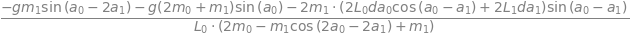

In [6]:
# Angular acceleration of the first link
ddang_0 = (
    -g * (2 * m[0] + m[1]) * sf.sin(ang[0])
    - m[1] * g * sf.sin(ang[0] - 2 * ang[1])
    - 2
    * sf.sin(ang[0] - ang[1])
    * m[1]
    * (dang[1] * 2 * L[1] + dang[0] * 2 * L[0] * sf.cos(ang[0] - ang[1]))
) / (L[0] * (2 * m[0] + m[1] - m[1] * sf.cos(2 * ang[0] - 2 * ang[1])))
display(ddang_0)

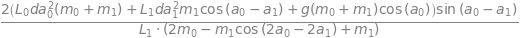

In [7]:
# Angular acceleration of the second link
ddang_1 = (
    2
    * sf.sin(ang[0] - ang[1])
    * (
        dang[0] ** 2 * L[0] * (m[0] + m[1])
        + g * (m[0] + m[1]) * sf.cos(ang[0])
        + dang[1] ** 2 * L[1] * m[1] * sf.cos(ang[0] - ang[1])
    )
) / (L[1] * (2 * m[0] + m[1] - m[1] * sf.cos(2 * ang[0] - 2 * ang[1])))
display(ddang_1)

Now let's organize the input symbols into a Values hierarchy:

In [8]:
inputs = Values()

inputs["ang"] = ang
inputs["dang"] = dang

with inputs.scope("constants"):
    inputs["g"] = g

with inputs.scope("params"):
    inputs["L"] = L
    inputs["m"] = m

display(inputs)

Values(
  ang: [a_0, a_1],
  dang: [da_0, da_1],
  constants:   Values(
    g: g,
  ),
  params:   Values(
    L: [L_0, L_1],
    m: [m_0, m_1],
  ),
)

The output will simply be a 2-vector of the angular accelerations:

In [9]:
outputs = Values(ddang=sf.V2(ddang_0, ddang_1))

display(outputs)

Values(
  ddang: [(-g*(2*m_0 + m_1)*sin(a_0) - g*sin(a_0 - 2*a_1)*m_1 - 2*sin(a_0 - a_1)*m_1*(2*L_1*da_1 + 2*cos(a_0 - a_1)*L_0*da_0))/(L_0*(2*m_0 + m_1 - cos(2*a_0 - 2*a_1)*m_1))]
[2*sin(a_0 - a_1)*(g*(m_0 + m_1)*cos(a_0) + (m_0 + m_1)*L_0*da_0**2 + cos(a_0 - a_1)*L_1*m_1*da_1**2)/(L_1*(2*m_0 + m_1 - cos(2*a_0 - 2*a_1)*m_1))],
)

Now run code generation to produce an executable module (in a temp directory if none provided):

In [10]:
double_pendulum = codegen.Codegen(
    inputs=inputs,
    outputs=outputs,
    config=codegen.CppConfig(),
    name="double_pendulum",
    return_key="ddang",
)
double_pendulum_data = double_pendulum.generate_function()

# Print what we generated
print("Files generated in {}:\n".format(double_pendulum_data.output_dir))
for f in double_pendulum_data.generated_files:
    print("  |- {}".format(f.relative_to(double_pendulum_data.output_dir)))

Files generated in /tmp/sf_codegen_double_pendulum_vhfn3e5x:

  |- lcmtypes/double_pendulum.lcm
  |- cpp/symforce/sym/double_pendulum.h


In [11]:
display_code_file(double_pendulum_data.function_dir / "double_pendulum.h", "C++")

// -----------------------------------------------------------------------------
// This file was autogenerated by symforce from template:
//     function/FUNCTION.h.jinja
// Do NOT modify by hand.
// -----------------------------------------------------------------------------

#pragma once

#include <Eigen/Core>

#include <lcmtypes/sym/constants_t.hpp>
#include <lcmtypes/sym/params_t.hpp>

namespace sym {

/**
 * This function was autogenerated. Do not modify by hand.
 *
 * Args:
 *     ang: Matrix12
 *     dang: Matrix12
 *     constants: Values
 *     params: Values
 *
 * Outputs:
 *     ddang: Matrix21
 */
template <typename Scalar>
Eigen::Matrix<Scalar, 2, 1> DoublePendulum(const Eigen::Matrix<Scalar, 1, 2>& ang,
                                           const Eigen::Matrix<Scalar, 1, 2>& dang,
                                           const sym::constants_t& constants,
                                           const sym::params_t& params) {
  // Total ops: 50

  // Input arrays

  // Intermediate terms (7)
  const Scalar _tmp0 = -2 * ang(0, 1);
  const Scalar _tmp1 = 2 * params.m.data()[0] + params.m.data()[1];
  const Scalar _tmp2 = Scalar(1.0) / (_tmp1 - params.m.data()[1] * std::cos(_tmp0 + 2 * ang(0, 0)));
  const Scalar _tmp3 = ang(0, 0) - ang(0, 1);
  const Scalar _tmp4 = std::cos(_tmp3);
  const Scalar _tmp5 = 2 * std::sin(_tmp3);
  const Scalar _tmp6 = params.m.data()[0] + params.m.data()[1];

  // Output terms (1)
  Eigen::Matrix<Scalar, 2, 1> _ddang;

  _ddang(0, 0) =
      _tmp2 *
      (-_tmp1 * constants.g * std::sin(ang(0, 0)) -
       _tmp5 * params.m.data()[1] *
           (2 * _tmp4 * dang(0, 0) * params.L.data()[0] + 2 * dang(0, 1) * params.L.data()[1]) -
       constants.g * params.m.data()[1] * std::sin(_tmp0 + ang(0, 0))) /
      params.L.data()[0];
  _ddang(1, 0) =
      _tmp2 * _tmp5 *
      (_tmp4 * std::pow(dang(0, 1), Scalar(2)) * params.L.data()[1] * params.m.data()[1] +
       _tmp6 * constants.g * std::cos(ang(0, 0)) +
       _tmp6 * std::pow(dang(0, 0), Scalar(2)) * params.L.data()[0]) /
      params.L.data()[1];

  return _ddang;
}  // NOLINT(readability/fn_size)

// NOLINTNEXTLINE(readability/fn_size)
}  // namespace sym

We can also generate functions with different function declarations:

In [12]:
# Function using structs as inputs and outputs (returned as pointer arg)
input_values = Values(inputs=inputs)
output_values = Values(outputs=outputs)
namespace = "double_pendulum"
double_pendulum_values = codegen.Codegen(
    inputs=input_values,
    outputs=output_values,
    config=codegen.CppConfig(),
    name="double_pendulum",
)
double_pendulum_values_data = double_pendulum_values.generate_function(
    namespace=namespace,
)

# Print what we generated. Note the nested structs that were automatically
# generated.
print("Files generated in {}:\n".format(double_pendulum_values_data.output_dir))
for f in double_pendulum_values_data.generated_files:
    print("  |- {}".format(f.relative_to(double_pendulum_values_data.output_dir)))

display_code_file(
    double_pendulum_values_data.function_dir / "double_pendulum.h",
    "C++",
)

Files generated in /tmp/sf_codegen_double_pendulum_38k60itm:

  |- lcmtypes/double_pendulum.lcm
  |- cpp/symforce/double_pendulum/double_pendulum.h


// -----------------------------------------------------------------------------
// This file was autogenerated by symforce from template:
//     function/FUNCTION.h.jinja
// Do NOT modify by hand.
// -----------------------------------------------------------------------------

#pragma once

#include <Eigen/Core>

#include <lcmtypes/double_pendulum/inputs_t.hpp>
#include <lcmtypes/double_pendulum/outputs_t.hpp>

namespace double_pendulum {

/**
 * This function was autogenerated. Do not modify by hand.
 *
 * Args:
 *     inputs: Values
 *
 * Outputs:
 *     outputs: Values
 */
template <typename Scalar>
void DoublePendulum(const double_pendulum::inputs_t& inputs,
                    double_pendulum::outputs_t* const outputs = nullptr) {
  // Total ops: 50

  // Input arrays

  // Intermediate terms (7)
  const Scalar _tmp0 = -2 * inputs.ang.data()[1];
  const Scalar _tmp1 = 2 * inputs.params.m.data()[0] + inputs.params.m.data()[1];
  const Scalar _tmp2 = Scalar(1.0) / (_tmp1 - inputs.params.m.data()[1] *
                                                  std::cos(_tmp0 + 2 * inputs.ang.data()[0]));
  const Scalar _tmp3 = inputs.ang.data()[0] - inputs.ang.data()[1];
  const Scalar _tmp4 = std::cos(_tmp3);
  const Scalar _tmp5 = 2 * std::sin(_tmp3);
  const Scalar _tmp6 = inputs.params.m.data()[0] + inputs.params.m.data()[1];

  // Output terms (1)
  if (outputs != nullptr) {
    double_pendulum::outputs_t& _outputs = (*outputs);

    _outputs.ddang.data()[0] =
        _tmp2 *
        (-_tmp1 * inputs.constants.g * std::sin(inputs.ang.data()[0]) -
         _tmp5 * inputs.params.m.data()[1] *
             (2 * _tmp4 * inputs.dang.data()[0] * inputs.params.L.data()[0] +
              2 * inputs.dang.data()[1] * inputs.params.L.data()[1]) -
         inputs.constants.g * inputs.params.m.data()[1] * std::sin(_tmp0 + inputs.ang.data()[0])) /
        inputs.params.L.data()[0];
    _outputs.ddang.data()[1] =
        _tmp2 * _tmp5 *
        (_tmp4 * std::pow(inputs.dang.data()[1], Scalar(2)) * inputs.params.L.data()[1] *
             inputs.params.m.data()[1] +
         _tmp6 * inputs.constants.g * std::cos(inputs.ang.data()[0]) +
         _tmp6 * std::pow(inputs.dang.data()[0], Scalar(2)) * inputs.params.L.data()[0]) /
        inputs.params.L.data()[1];
  }
}  // NOLINT(readability/fn_size)

// NOLINTNEXTLINE(readability/fn_size)
}  // namespace double_pendulum

Finally, we can generate the same function in other languages as well:

In [13]:
namespace = "double_pendulum"
double_pendulum_python = codegen.Codegen(
    inputs=inputs,
    outputs=outputs,
    config=codegen.PythonConfig(use_eigen_types=False),
    name="double_pendulum",
    return_key="ddang",
)
double_pendulum_python_data = double_pendulum_python.generate_function(
    namespace=namespace,
)

print("Files generated in {}:\n".format(double_pendulum_python_data.output_dir))
for f in double_pendulum_python_data.generated_files:
    print("  |- {}".format(f.relative_to(double_pendulum_python_data.output_dir)))

display_code_file(
    double_pendulum_python_data.function_dir / "double_pendulum.py",
    "python",
)

2 files left unchanged
Files generated in /tmp/sf_codegen_double_pendulum_mn1e69vc:

  |- lcmtypes/double_pendulum.lcm
  |- python/symforce/double_pendulum/double_pendulum.py
  |- python/symforce/double_pendulum/__init__.py


# -----------------------------------------------------------------------------
# This file was autogenerated by symforce from template:
#     function/FUNCTION.py.jinja
# Do NOT modify by hand.
# -----------------------------------------------------------------------------

# ruff: noqa: F401, PLR0912, PLR0913, PLR0914, PLR0915, PLR0917, RUF100

import math
import typing as T

import numpy

import sym


def double_pendulum(ang, dang, constants, params):
    # type: (numpy.ndarray, numpy.ndarray, T.Any, T.Any) -> numpy.ndarray
    """
    This function was autogenerated. Do not modify by hand.

    Args:
        ang: Matrix12
        dang: Matrix12
        constants: Values
        params: Values

    Outputs:
        ddang: Matrix21
    """

    # Total ops: 50

    # Input arrays
    if ang.shape == (2,):
        ang = ang.reshape((1, 2))
    elif ang.shape != (1, 2):
        raise IndexError(
            "ang is expected to have shape (1, 2) or (2,); instead had shape {}".format(ang.shape)
        )

    if dang.shape == (2,):
        dang = dang.reshape((1, 2))
    elif dang.shape != (1, 2):
        raise IndexError(
            "dang is expected to have shape (1, 2) or (2,); instead had shape {}".format(dang.shape)
        )

    # Intermediate terms (7)
    _tmp0 = -2 * ang[0, 1]
    _tmp1 = 2 * params.m[0] + params.m[1]
    _tmp2 = 1 / (_tmp1 - params.m[1] * math.cos(_tmp0 + 2 * ang[0, 0]))
    _tmp3 = ang[0, 0] - ang[0, 1]
    _tmp4 = math.cos(_tmp3)
    _tmp5 = 2 * math.sin(_tmp3)
    _tmp6 = params.m[0] + params.m[1]

    # Output terms
    _ddang = numpy.zeros(2)
    _ddang[0] = (
        _tmp2
        * (
            -_tmp1 * constants.g * math.sin(ang[0, 0])
            - _tmp5
            * params.m[1]
            * (2 * _tmp4 * dang[0, 0] * params.L[0] + 2 * dang[0, 1] * params.L[1])
            - constants.g * params.m[1] * math.sin(_tmp0 + ang[0, 0])
        )
        / params.L[0]
    )
    _ddang[1] = (
        _tmp2
        * _tmp5
        * (
            _tmp4 * dang[0, 1] ** 2 * params.L[1] * params.m[1]
            + _tmp6 * constants.g * math.cos(ang[0, 0])
            + _tmp6 * dang[0, 0] ** 2 * params.L[0]
        )
        / params.L[1]
    )
    return _ddang

In [14]:
constants_t = codegen_util.load_generated_lcmtype(
    namespace, "constants_t", double_pendulum_python_data.python_types_dir
)

params_t = codegen_util.load_generated_lcmtype(
    namespace, "params_t", double_pendulum_python_data.python_types_dir
)

ang = np.array([[0.0, 0.5]])
dang = np.array([[0.0, 0.0]])
consts = constants_t()
consts.g = 9.81
params = params_t()
params.L = [0.5, 0.3]
params.m = [0.3, 0.2]

double_pendulum = codegen_util.load_generated_function(
    "double_pendulum", double_pendulum_python_data.function_dir
)
double_pendulum(ang, dang, consts, params)

array([  4.77199518, -22.65691471])